In [2]:
!pip install pynrrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Liberaries 

In [37]:
import cv2
import numpy as np
import nrrd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import skimage.io as io
import os
import skimage.util as util
import skimage.color as color
import plotly.graph_objs as go
from skimage import measure
from ipywidgets import interact, FloatSlider

# Task 1.1

In [38]:
# Read the NRRD file
data, header = nrrd.read('CTA-Abdomen.nrrd')

# Calculate the midpoint of each dimension
mid_sagittal = data.shape[0] // 2
mid_coronal = data.shape[1] // 2
mid_axial = data.shape[2] // 2

# Extract the middle slice from each dimension
mid_sagittal_img = data[mid_sagittal, :, :]
mid_coronal_img = data[:, mid_coronal, :]
mid_axial_img = data[:, :, mid_axial]


(-0.5, 320.5, 214.5, -0.5)

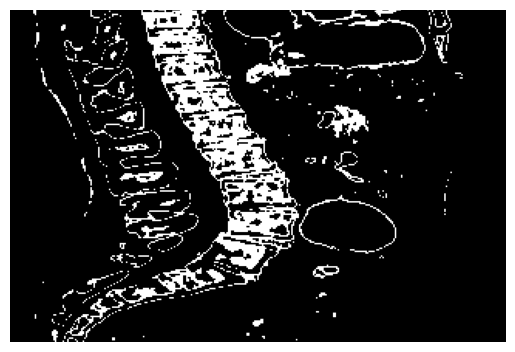

In [39]:
# Set the threshold values for the image
img_threshold_high = 210
img_threshold_low = 90

# Assign the input image to a new variable
image = mid_sagittal_img

# Create a new array filled with zeros to represent the binary image
img = np.zeros(image.shape)

# Set all values in the binary image to 1 where the original image values are within the threshold range
img[(image <= img_threshold_high) & (image > img_threshold_low)] = 1

# Display the binary image with gray colormap and turn off the axis
plt.imshow(np.rot90(img), cmap='gray')
plt.axis('off')


# Task 1.2

In [40]:
min_val = np.min(mid_sagittal_img)
max_val = np.max(mid_sagittal_img)

# Shift the pixel values so that the minimum value becomes zero
img_shifted = mid_sagittal_img - min_val


# Scale the pixel values so that the maximum value becomes 255
img_scaled = img_shifted * 255.0 / (max_val - min_val)

# Convert the pixel values to uint8 type
image = np.uint8(img_scaled)

image =  cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

Different threshold functions

In [41]:
def binary_threshold (image):
    # Define the range of intensity values to be displayed
    min_intensity = 115
    max_intensity = 170

    # Create a lookup table to map pixel values to display range
    lookup_table = np.zeros((256,), dtype=np.uint8)
    for i in range(256):
        if i < min_intensity:
            lookup_table[i] = 0
        elif i > max_intensity:
            lookup_table[i] = 0
        else:
            lookup_table[i] = 255

    # Apply the lookup table to the image
    thresh = cv2.LUT(image, lookup_table)
    return thresh

In [42]:
def binary_mask (image):
    image = cv2.equalizeHist(image)
    _, thresh = cv2.threshold(image, 190, 255, cv2.THRESH_BINARY)
    return thresh

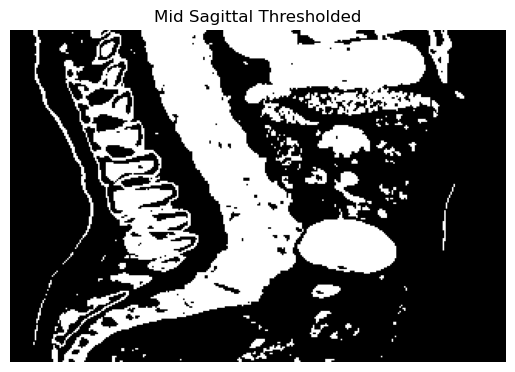

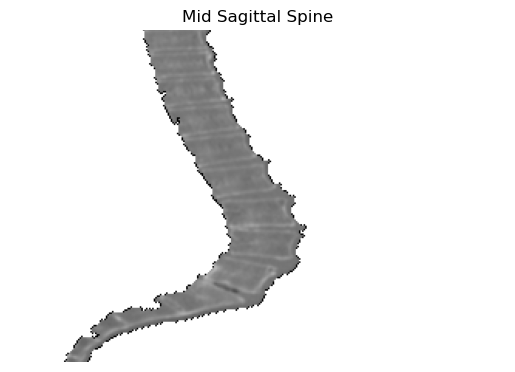

In [43]:
# Define a function called image_mask that takes an input image as argument
def image_mask(image, threshold_func):

    # Declare global variables for threshold, output, and mask
    global thresh, output, mask

    # Apply binary thresholding to the input image using a separate function called binary_threshold
    thresh = threshold_func

    # Apply morphological operations to the binary image to remove small objects and fill in gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    # Find contours in the binary image using cv2.findContours
    contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the original image and create a mask with the same shape as the input image
    for i in range(len(contours)):
        # Draw the maximum contour only if its area is greater than 300 pixels
        if cv2.contourArea(contours[i]) > 300:
            rect = cv2.minAreaRect(contours[i])
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            mask = 255 * np.ones(image.shape, np.uint8)
            mask = cv2.drawContours(mask, contours[i], -1, (0, 0, 255), 2)
            [mm, mn] = image.shape
            for rr in range(mm):
                for cc in range(mn):
                    if cv2.pointPolygonTest(contours[i], (rr, cc), False) >= 0:
                        mask[cc][rr] = image[cc][rr]

    # Return the resulting mask
    return mask

# Call the image_mask function with the input image and display the resulting binary image
image_mask(image, binary_threshold (image))
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.title("Mid Sagittal Thresholded")
plt.show()

# Display the resulting mask image
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title("Mid Sagittal Spine")
plt.show()


The number of boxes is: 10


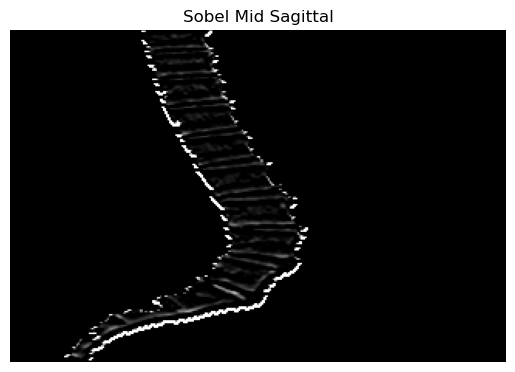

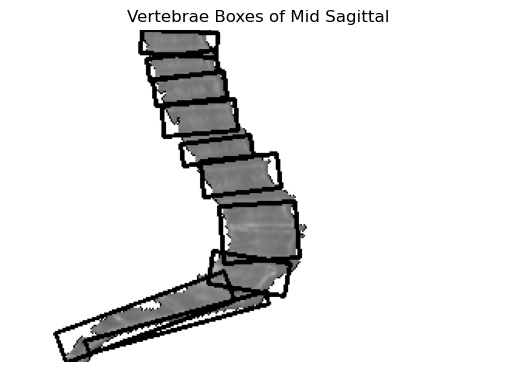

In [44]:
def get_contours (mask): 
    
    global out, sobely , laplacian
    # Apply the Laplacian filter to the mask image
    laplacian = cv2.Laplacian(mask,cv2.CV_64F)
    # Apply the Sobel filter to the mask image to find edges in the x-direction
    sobely = cv2.Sobel(mask,cv2.CV_8UC1,0,1,ksize=3)

    # Find contours in the binary image using the Sobel edge detection
    contours, hierarchy = cv2.findContours(sobely, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original mask image to draw contours on
    out=mask.copy()

    # Loop through each contour and draw a bounding box around it if it meets certain criteria
    counter=0
    for i in range(len(contours)):
        # Check if the contour area is between 150 and 1500 pixels
        if cv2.contourArea(contours[i])>150 and cv2.contourArea(contours[i])<1500  :
            # Get the minimum area rectangle that encloses the contour
            rect = cv2.minAreaRect(contours[i])
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            # Draw the bounding box on the copy of the mask image
            cv2.drawContours(out,[box],0,(0,0,255),2)
            counter+=1

    print("The number of boxes is:" , counter)
    return out


get_contours (mask)

plt.imshow(sobely, cmap='gray')
plt.axis('off')
plt.title("Sobel Mid Sagittal")
plt.show()

plt.imshow(out, cmap='gray')
plt.axis('off')
plt.title("Vertebrae Boxes of Mid Sagittal")
plt.show()


# Trials of 3d Boxes

Load only slices of the middel, one before and one after to try on

The number of boxes is: 7


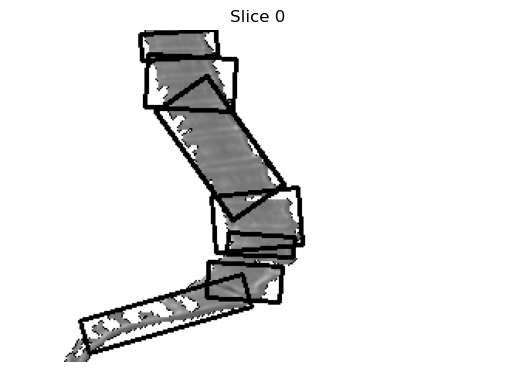

The number of boxes is: 6


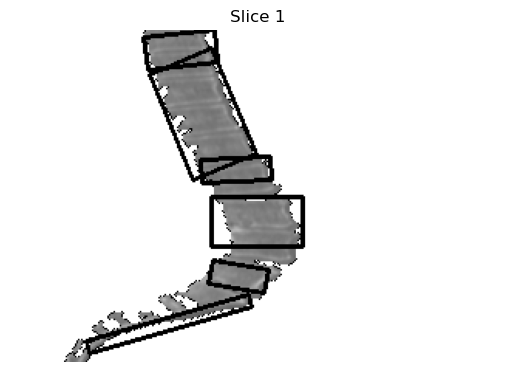

The number of boxes is: 8


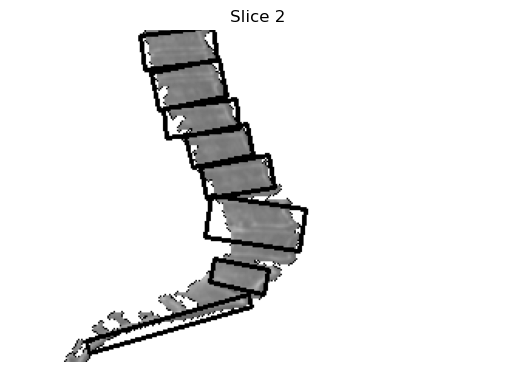

The number of boxes is: 7


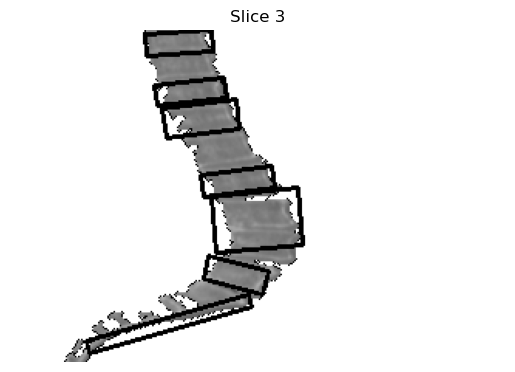

The number of boxes is: 8


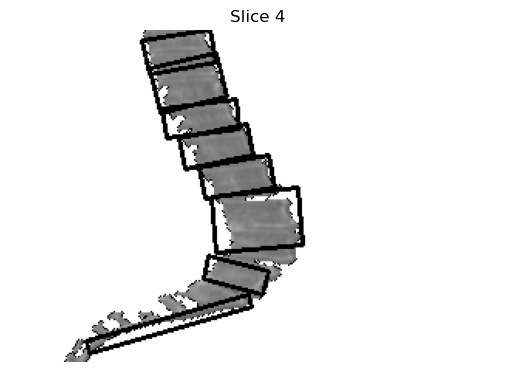

The number of boxes is: 8


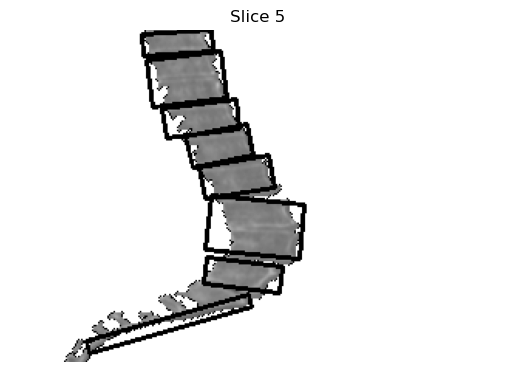

The number of boxes is: 9


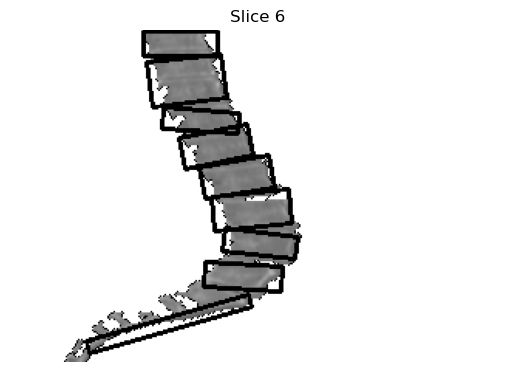

The number of boxes is: 6


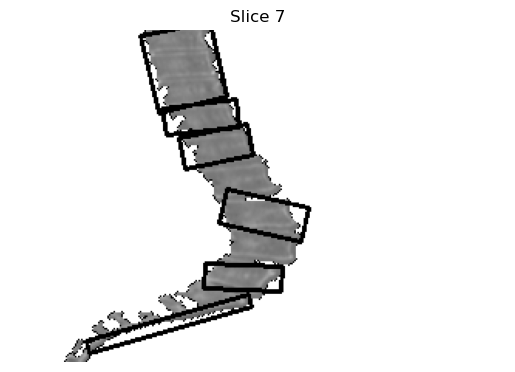

The number of boxes is: 8


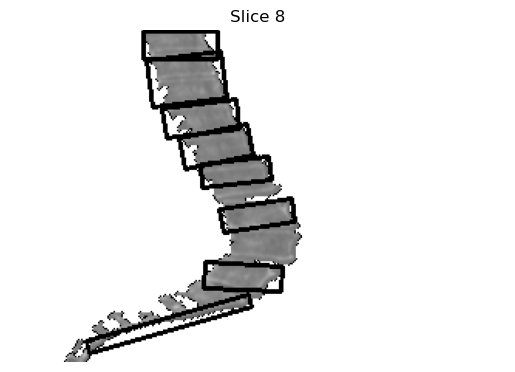

The number of boxes is: 9


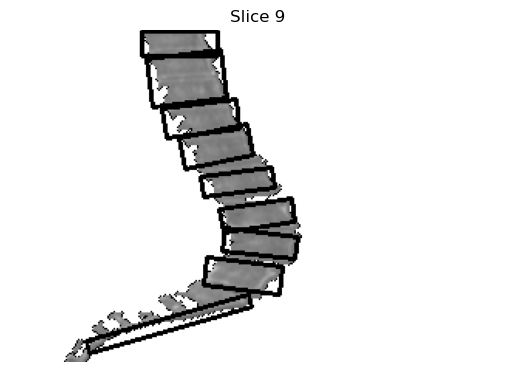

The number of boxes is: 8


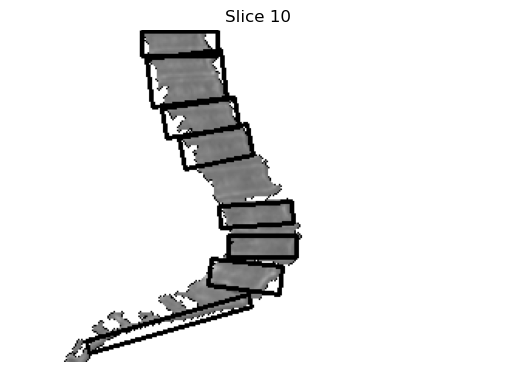

The number of boxes is: 8


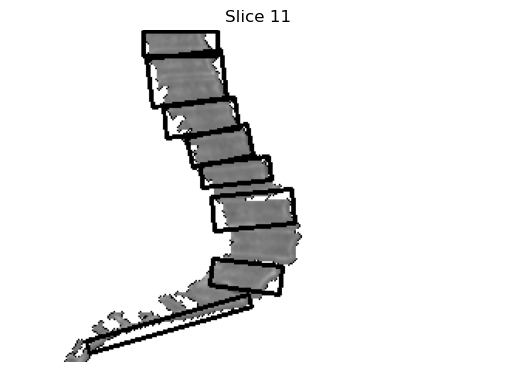

The number of boxes is: 9


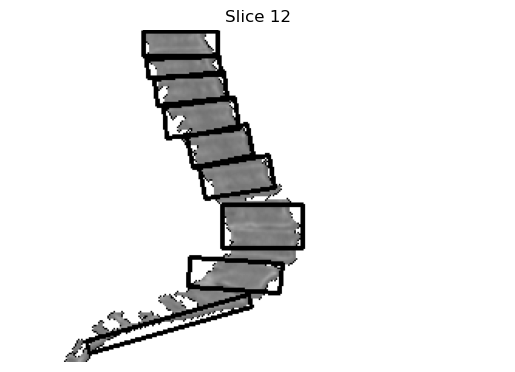

The number of boxes is: 7


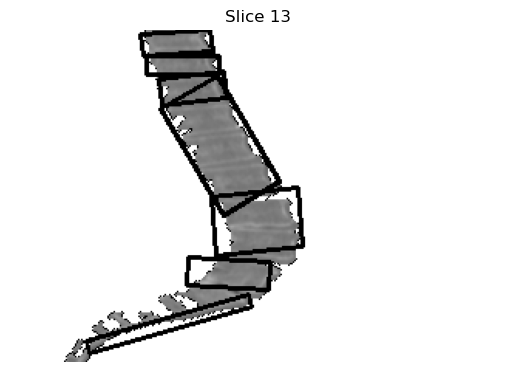

The number of boxes is: 8


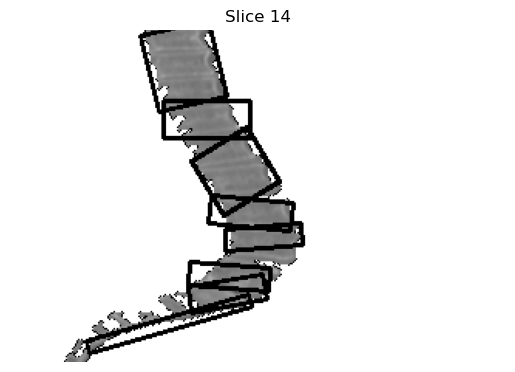

The number of boxes is: 9


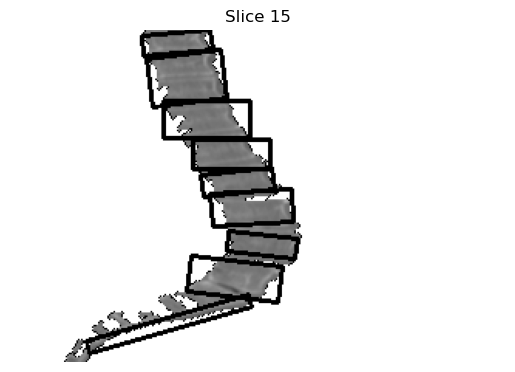

The number of boxes is: 8


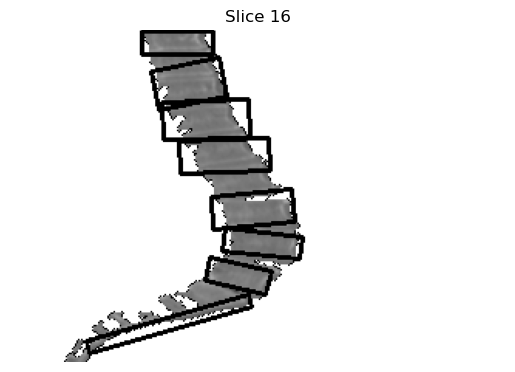

The number of boxes is: 7


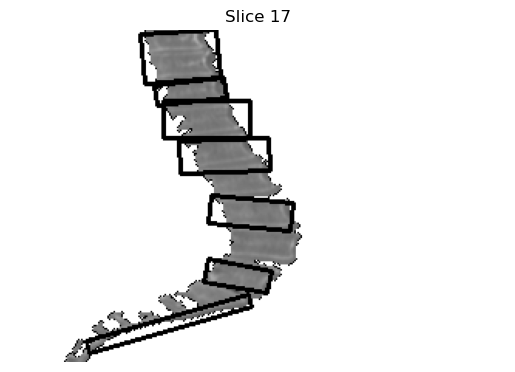

The number of boxes is: 9


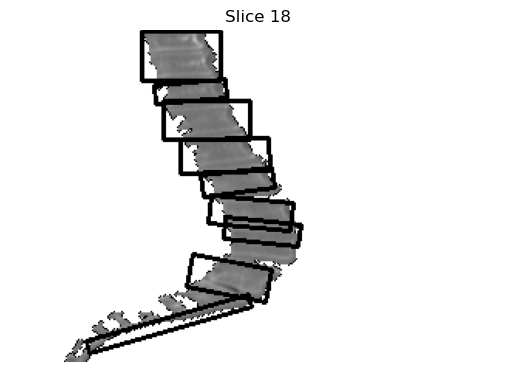

The number of boxes is: 7


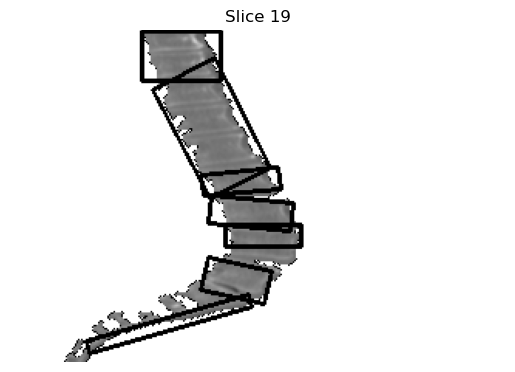

The number of boxes is: 8


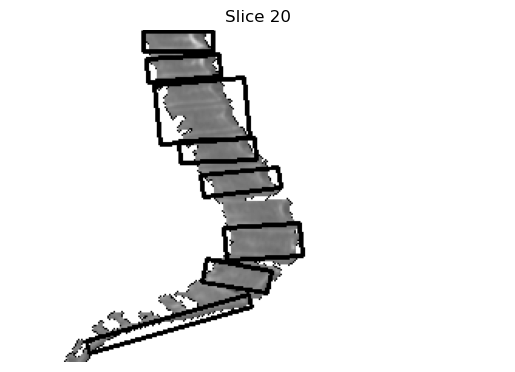

In [46]:
data, header = nrrd.read('CTA-Abdomen.nrrd')

# Define the number of slices to load before and after the mid-sagittal slice
num_slices = 1   #should be 10 for the task

# Load the mid-sagittal slice and the slices before and after it
mid_sagittal = data.shape[0] // 2
start_slice = mid_sagittal - num_slices
end_slice = mid_sagittal + num_slices
image_data = [data[i, :, :] for i in range(start_slice, end_slice + 1)]

# Convert each slice to uint8 type
images = []
for i, img in enumerate(image_data):
    min_val = np.min(img)
    max_val = np.max(img)
    img_shifted = img - min_val
    img_scaled = img_shifted * 255.0 / (max_val - min_val)
    img_uint8 = np.uint8(img_scaled)
    final = cv2.rotate(img_uint8, cv2.ROTATE_90_COUNTERCLOCKWISE)
    images.append(final)

volume = np.stack(images, axis=-1)
    
if not os.path.exists("test"):
    os.makedirs("test")
    
x,y,z = volume.shape
for i in range (0,z):
    slice_indx =volume[:,:,i]
    image_mask (slice_indx,binary_mask (image))
    get_contours (mask)
    plt.imshow(out, cmap='gray')
    plt.axis('off')
    plt.title("Slice " + str(i))
    plt.savefig(f"test/slice_{i}.png")  # Save the image to subfolder "test"
    plt.show()


Load The saved images

In [12]:
image_path = 'test'
image_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.png')]
images = io.imread_collection(image_files)
# Convert each image to grayscale
gray_images = [color.rgb2gray(image[:, :, :3]) for image in images]
gray_images = np.array (gray_images)
print(gray_images[1].shape)

(372, 515)


Try to plot the boxes

In [13]:
# Use marching cubes algorithm for volumetric rendering
def plot_3d(threshold, elev, azim):
    # Use marching cubes algorithm for volumetric rendering
    verts, faces, normals, values = measure.marching_cubes(gray_images, threshold)

    # Visualize the 3D image using Matplotlib
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(verts[:, 2], verts[:, 0], faces, verts[:, 1],
                    shade=True, color="none", alpha=0.3, edgecolor="none")
    ax.view_init(elev=elev, azim=azim) #Adjust the viewing angle
    plt.show()

# Create the slider widgets
threshold_slider = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.0)
elev_slider = FloatSlider(min=0, max=360, step=10, value=180)
azim_slider = FloatSlider(min=0, max=360, step=10, value=270)

# Call the interactive function using the slider widgets
interact(plot_3d, threshold=threshold_slider, elev=elev_slider, azim=azim_slider)


interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.01), FloatSlider(value=1â€¦

<function __main__.plot_3d(threshold, elev, azim)>